In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from configobj import ConfigObj
from itertools import chain
import os, glob
import shutil
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.constants as const
from dustmaps.sfd import SFDQuery
from dust_extinction.parameter_averages import CCM89, G23

In [2]:
#define paramters to be modified in default config file
#for any section that requires paramters to be edited, include it in 'sed_modules_params'
CIGALE_PARAMS = {'sed_modules': ['sfhdelayed', 'bc03', 'nebular', 'dustatt_calzleit', 'dale2014', 'redshifting'],
                 'analysis_method': "pdf_analysis",
                 'sed_modules_params': {
                     'sfhdelayed': {
                        'tau_main': ['250', '500', '1000', '2000', '4000', '6000', '8000'],
                        'age_main': ['250', '500', '1000', '2000', '4000', '8000', '12000'],
                     },
                     'bc03': {
                         'imf': 1,
                         'metallicity': ['0.0001', '0.0004', '0.004', '0.008', '0.02', '0.05'],
                     },
                     'dustatt_calzleit': {
                         'E_BVs_young': ['0.0', '0.2', '0.3', '0.5', '0.8', '1.0', '1.5', '2.0', '3.0'],
                         'E_BVs_old_factor': ['0.3', '0.5', '1.0'],
                         'uv_bump_amplitude': ['0.0', '1.0', '2.0', '3.0'],
                         'powerlaw_slope': ['-0.13', '-0.2', '-0.5']
                     },
                     'dale2014': {
                         'alpha': ['1.0', '1.5', '2.0', '2.5'],
                     }
                 },
                 'analysis_params': {
                     'save_best_sed': True,
                 }}

In [3]:
CIGALE_PTF_FILTERS = ['GALEX_FUV', 'GALEX_NUV', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                      'PANSTARRS_g', 'PANSTARRS_r', 'PANSTARRS_i', 'PANSTARRS_z', 'PANSTARRS_y',
                      'CFHT_u', 'CFHT_g', 'CFHT_r', 'CFHT_i', 'CFHT_z', 'LS_g', 'LS_r', 'LS_z',
                      '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_W1', 'WISE_W2']

In [4]:
pivot_lambda = [153.51*u.nm, 230.08*u.nm, 350.10*u.nm, 476.31*u.nm, 624.70*u.nm, 771.83*u.nm, 1.08*u.um,
                484.91*u.nm, 620.12*u.nm, 753.50*u.nm, 867.42*u.nm, 962.78*u.nm,
                364.75*u.nm, 474.15*u.nm, 637.55*u.nm, 767.88*u.nm, 900.66*u.nm, 480.85*u.nm, 641.76*u.nm, 916.89*u.nm,
                1.24*u.um, 1.65*u.um, 2.16*u.um, 3.37*u.um, 4.62*u.um]
CIGALE_PTF_LAMBDA = dict(zip(CIGALE_PTF_FILTERS, pivot_lambda))

In [5]:
def prep_cigale(data_file, params):

    subprocess.run(["pcigale", "init"])
    configfile = 'pcigale.ini'

    #read in configfile
    config = ConfigObj(configfile, encoding = 'utf-8')
    config.filename = configfile

    #edit params
    config['data_file'] = data_file
    config['sed_modules'] = params['sed_modules']
    config['analysis_method'] = params['analysis_method']
    config.write()
    
    #generate config file to run cigale
    try:
        subprocess.run(["pcigale", "genconf"])
    except:
        raise ValueError("Could not create config file - check defaults")
    
    #read configfile again as it has been modified by genconf
    config = ConfigObj(configfile, encoding = 'utf-8')
    config.filename = configfile
    
    #genconf will overwrite any edits, so modify paramters at the end
    for module_ in params['sed_modules']:
        if module_ in params['sed_modules_params'].keys():
            mod = params['sed_modules_params'][module_]
            for key, value in mod.items():
                config['sed_modules_params'][module_][key] = value

    if 'analysis_params' in params.keys():
        for key, value in params['analysis_params'].items():
            config['analysis_params'][key] = value
    config.write()

    #verify if config file is ok
    try:
        subprocess.run(["pcigale", "check"])
    except:
        raise ValueError("Config file in incorrect")
    
    return config

In [6]:
def run_cigale(configfile, data_file, outdir, plot=False):
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    #copy everything to outdir
    shutil.copy(configfile, os.path.join(outdir, configfile))
    shutil.copy(configfile + '.spec', os.path.join(outdir, configfile + '.spec'))
    shutil.copy(data_file, os.path.join(outdir, data_file))

    cwd = os.getcwd()
    os.chdir(outdir)

    #run cigale
    subprocess.run(["pcigale", "run"])
    if plot:
        subprocess.run(["pcigale-plots", "sed"])
    os.chdir(cwd)

In [7]:
def read_ptf_sample(filename):
    try:
        ptf_sne = pd.read_csv(filename, header = None, names=['SN', 'telescope', 'instrument', 'filter', 'mag', 'magerr', 'ref'])
        ptf_sne['SN'] = ptf_sne['SN'].str.strip()
        ptf_sne['telescope'] = ptf_sne['telescope'].str.strip()
        ptf_sne['instrument'] = ptf_sne['instrument'].str.strip()
        ptf_sne['filter'] = ptf_sne['filter'].str.strip()
        ptf_sne['ref'] = ptf_sne['ref'].str.strip()
        
        return ptf_sne
    except:
        raise ValueError('Reformat input file with correct whitespaces and delimiters')

In [9]:
def read_ptf_redshifts(filename):
    try:
        redshifts = pd.read_csv(filename, header = None, usecols = [0, 1, 2, 5, 6, 7, 8, 9, 10],  names = ['SN', 'Type', 'z', 'RAh', 'RAm', 'RAs', 'Decd', 'Decm', 'Decs'])
        redshifts['RA'] = redshifts['RAh'].astype(str) + ':' + redshifts['RAm'].astype(str) + ':' + redshifts['RAs'].astype(str)
        redshifts['Dec'] = redshifts['Decd'].astype(str) + ':' + redshifts['Decm'].astype(str) + ':' + redshifts['Decs'].astype(str)
        redshifts = redshifts.drop(columns=['RAh', 'RAm', 'RAs', 'Decd', 'Decm', 'Decs'])
        redshifts['SN'] = redshifts['SN'].str.strip()
        redshifts['Type'] = redshifts['Type'].str.strip()

        return redshifts
    
    except:
        raise ValueError('Reformat input file with correct whitespaces and delimiters')

In [10]:
def mw_extinction(sn, redshifts, filters, verbose=False):
    # Get SN coordinates from redshifts table
    ra = redshifts[redshifts['SN'] == sn]['RA']
    dec = redshifts[redshifts['SN'] == sn]['Dec']
    coord = SkyCoord(ra=ra, dec=dec, unit = (u.hourangle, u.deg), frame='icrs')

    # Query SFD dust map for E(B-V)
    sfd = SFDQuery()
    ebv = sfd(coord)[0]
    R_V = 3.1

    # Use extinction law from Gordon+23
    ext = G23(Rv = R_V)
    out_ext = dict.fromkeys(filters)
    for flt_ in filters:
        wv = CIGALE_PTF_LAMBDA[flt_]
        a_lambda = ext(wv)
        A_lambda = a_lambda * ebv
        if verbose:
            print(f'A_lambda for {sn} in {flt_} is {A_lambda}')
        out_ext[flt_] = A_lambda

    return out_ext

In [11]:
def get_sn_data(sn, ptf_sne, redshifts, verbose=False):

    # Read mags, redshift and filters
    dat = ptf_sne[ptf_sne['SN'].str.lower() == sn.lower()]
    z = redshifts[redshifts['SN'].str.lower() == sn.lower()]['z'].iloc[0]
    filters = dat['telescope'] + '_' + dat['filter']
    mag, err = np.array(dat['mag']), np.array(dat['magerr'])

    maglist, errlist = [], []
    for f in CIGALE_PTF_FILTERS:
        if f in list(filters):
            idx = list(filters).index(f)
            # Correct photometry for MW extinction
            mwext = mw_extinction(sn, redshifts, [f], verbose=verbose)[f]
            if verbose:
                print(f'MW extinction for {sn} in {f}: {mag[idx]} -> {mag[idx] - mwext}')
            maglist.append(mag[idx] - mwext); errlist.append(err[idx])
        else:
            maglist.append(np.nan); errlist.append(np.nan)

    maglist, errlist = np.array(maglist), np.array(errlist)
    phot_points = len(maglist[~np.isnan(maglist)])

    # Convert magnitudes to flux in mJy as required by CIGALE
    flux = 10**((maglist - 8.90)/-2.5)*1000
    fluxerr = errlist * flux * np.log(10)/2.5

    # Output string for CIGALE data file
    line = [f'{i} {j}' for i, j in zip(flux, fluxerr)]
    line = ' '.join(line)
    row = f'{sn} {z} ' + line

    return row, phot_points

In [12]:
def prep_cigale_datafile(filename, sne, ptf_sne, redshifts, verbose=False):
    rows = []
    # Get extinction corrected photomtery
    for sn in sne:
        row_, phot_points = get_sn_data(sn, ptf_sne, redshifts, verbose=verbose)
        if phot_points < 4:
            print(f'Skipping {sn} with {phot_points} data points')
            continue
        else:
            rows.append(row_)
    
    # Write out into datafile
    with open(filename, 'a') as f:
        f.write('\n'.join(rows))

In [12]:
ptf_sne = read_ptf_sample('ptf_ccsne.csv')
ptf_sne = ptf_sne[ptf_sne['ref'] == 'This paper']

redshifts = read_ptf_redshifts('ptf_ccsne_redshifts.csv')
redshifts = redshifts[redshifts['SN'].isin(ptf_sne['SN'])]

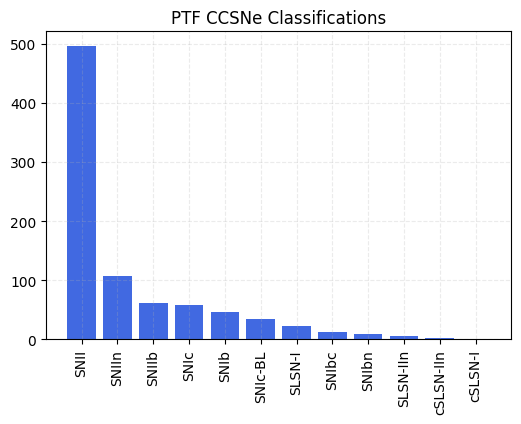

In [13]:
types, counts = np.unique(redshifts['Type'], return_counts=True)
sort = np.argsort(counts)[::-1]
types, counts = types[sort], counts[sort]
plt.figure(figsize = (6, 4))
plt.bar(*(types, counts), color = 'royalblue')
plt.grid(alpha = 0.25, linestyle = '--')
plt.title('PTF CCSNe Classifications')
_ = plt.xticks(rotation = 90)

In [51]:
# Narrow line SNe
type_n = ['SNIIn', 'SNIbn']
narrow_sne = redshifts[redshifts['Type'].isin(type_n)]['SN'].to_numpy()

# Type Ibc SNe
type_Ibc = ['SNIb', 'SNIbc', 'SNIc', 'SNIc-BL']
type_Ibc_sne = redshifts[redshifts['Type'].isin(type_Ibc)]['SN'].to_numpy()

# Superluminous SNe
sl_sne = redshifts[redshifts['Type'].str.contains('SLSN')]['SN'].to_numpy()

# Type II SNe
type_II = ['SNII', 'SNIIb']
type_II_sne = redshifts[redshifts['Type'].isin(type_II)]['SN'].to_numpy()

In [54]:
data_file = 'ztf_fbots_cigale.txt'
ptf = False
if ptf:
    prep_cigale_datafile(data_file, sl_sne, ptf_sne, redshifts, verbose=False)

In [56]:
config = prep_cigale(data_file, CIGALE_PARAMS)

╭──────────────────────────────────────────────────────────────────────────────╮
│                      Code Investigating GALaxy Emission                      │
│                Boquien et al. (2019) (]8;id=215646;https://cigale.lam.fr\https://cigale.lam.fr]8;;\)                 │
│         CIGALE version: 2025.0 — Python version: 3.12.0 — Platform:          │
│                              macosx-11.1-arm64                               │
╰───────────────────────────���──────────────────────────────────────────────────╯


                                  SED modules                                   
╭──────────────────────┬───────────────────────────────────────────────────────╮
│ SFH                  │ None. Options are: sfh2exp, sfh_buat08, sfhdelayed,   │
│                      │ sfhdelayedbq, sfhfromfile, sfhperiodic.               │
│ SSP                  │ None. Options are: bc03, bpassv2, cb19, m2005.        │
│ nebular              │ None. Options are: nebular.         

In [57]:
run_cigale('pcigale.ini', data_file, 'ztffbots', plot=True)

╭──────────────────────────────────────────────────────────────────────────────╮
│                      Code Investigating GALaxy Emission                      │
│                Boquien et al. (2019) (]8;id=606716;https://cigale.lam.fr\https://cigale.lam.fr]8;;\)                 │
│         CIGALE version: 2025.0 — Python version: 3.12.0 — Platform:          │
│                              macosx-11.1-arm64                               │
╰───────────────────────────���──────────────────────────────────────────────────╯


                              General information                               
╭───────────────────┬──────────────────────────────────────────────────────────╮
│ Data file         │ ztf_fbots_cigale.txt                                     │
│ Parameters file   │ None                                                     │
│ Number of objects │ 28                                                       │
│ Redshift          │ 0.01 to 0.27                           

In [17]:
res_hdul = fits.open('ptfIIsne/out/results.fits')
results = Table(res_hdul[1].data)

obs_hdul = fits.open('ptfIIsne/out/observations.fits')
obs = Table(obs_hdul[1].data)

In [18]:
results

id,bayes.agn.fracAGN_dale2014,bayes.agn.fracAGN_dale2014_err,bayes.attenuation.E_BVs.nebular.emission_old,bayes.attenuation.E_BVs.nebular.emission_old_err,bayes.attenuation.E_BVs.nebular.emission_young,bayes.attenuation.E_BVs.nebular.emission_young_err,bayes.attenuation.E_BVs.stellar.old,bayes.attenuation.E_BVs.stellar.old_err,bayes.attenuation.E_BVs.stellar.young,bayes.attenuation.E_BVs.stellar.young_err,bayes.attenuation.ebvs_old_factor,bayes.attenuation.ebvs_old_factor_err,bayes.attenuation.galex.FUV,bayes.attenuation.galex.FUV_err,bayes.attenuation.generic.bessell.B,bayes.attenuation.generic.bessell.B_err,bayes.attenuation.generic.bessell.V,bayes.attenuation.generic.bessell.V_err,bayes.attenuation.powerlaw_slope,bayes.attenuation.powerlaw_slope_err,bayes.attenuation.uv_bump_amplitude,bayes.attenuation.uv_bump_amplitude_err,bayes.attenuation.uv_bump_wavelength,bayes.attenuation.uv_bump_wavelength_err,bayes.attenuation.uv_bump_width,bayes.attenuation.uv_bump_width_err,bayes.dust.alpha,bayes.dust.alpha_err,bayes.nebular.f_dust,bayes.nebular.f_dust_err,bayes.nebular.f_esc,bayes.nebular.f_esc_err,bayes.nebular.lines_width,bayes.nebular.lines_width_err,bayes.nebular.logU,bayes.nebular.logU_err,bayes.nebular.ne,bayes.nebular.ne_err,bayes.nebular.zgas,bayes.nebular.zgas_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.age_burst,bayes.sfh.age_burst_err,bayes.sfh.age_main,bayes.sfh.age_main_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,bayes.sfh.tau_burst,bayes.sfh.tau_burst_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.stellar.age_m_star,bayes.stellar.age_m_star_err,bayes.stellar.imf,bayes.stellar.imf_err,bayes.stellar.metallicity,bayes.stellar.metallicity_err,bayes.stellar.old_young_separation_age,bayes.stellar.old_young_separation_age_err,bayes.universe.age,bayes.universe.age_err,bayes.universe.luminosity_distance,bayes.universe.luminosity_distance_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.attenuation.nebular.emission_old,bayes.attenuation.nebular.emission_old_err,bayes.attenuation.nebular.emission_young,bayes.attenuation.nebular.emission_young_err,bayes.attenuation.stellar.old,bayes.attenuation.stellar.old_err,bayes.attenuation.stellar.young,bayes.attenuation.stellar.young_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.sfh.integrated,bayes.sfh.integrated_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.stellar.lum,bayes.stellar.lum_err,bayes.stellar.lum_ly,bayes.stellar.lum_ly_err,bayes.stellar.lum_ly_old,bayes.stellar.lum_ly_old_err,bayes.stellar.lum_ly_young,bayes.stellar.lum_ly_young_err,bayes.stellar.lum_old,bayes.stellar.lum_old_err,bayes.stellar.lum_young,bayes.stellar.lum_young_err,bayes.stellar.m_gas,bayes.stellar.m_gas_err,bayes.stellar.m_gas_old,bayes.stellar.m_gas_old_err,bayes.stellar.m_gas_young,bayes.stellar.m_gas_young_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.stellar.m_star_old,bayes.stellar.m_star_old_err,bayes.stellar.m_star_young,bayes.stellar.m_star_young_err,bayes.stellar.n_ly,bayes.stellar.n_ly_err,bayes.stellar.n_ly_old,bayes.stellar.n_ly_old_err,bayes.stellar.n_ly_young,bayes.stellar.n_ly_young_err,bayes.2mass.H,bayes.2mass.H_err,bayes.2mass.J,bayes.2mass.J_err,bayes.2mass.Ks,bayes.2mass.Ks_err,bayes.cfht.megaprime.g,bayes.cfht.megaprime.g_err,bayes.cfht.megaprime.i,bayes.cfht.megaprime.i_err,bayes.cfht.megaprime.r,bayes.cfht.megaprime.r_err,bayes.cfht.megaprime.u,bayes.cfht.megaprime.u_err,bayes.cfht.megaprime.z,bayes.cfht.megaprime.z_err,bayes.ctio.ls.g,bayes.ctio.ls.g_err,bayes.ctio.ls.r,bayes.ctio.ls.r_err,bayes.ctio.ls.z,bayes.ctio.ls.z_err,bayes.galex.FUV,bayes.galex.FUV_err,bayes.galex.NUV,bayes.galex.NUV_err,bayes.panstarrs.ps1.g,bayes.panstarrs.ps1.g_err,bayes.panstarrs.ps1.i,bayes.panstarrs.ps1.i_err,bayes.panstarrs.ps1.r,bayes.panstarrs.ps1.r_err,bayes.panstarrs.ps1.y,bayes.panstarrs.ps1.y_err,bayes.panstarrs.ps1.z,bayes.panstarrs.ps1.z_err,bayes.sloan.sdss.gprime,bay

In [19]:
subtable = results[['id', 'best.chi_square', 'best.reduced_chi_square']]
subtable['log_stellar_mass'] = np.log10(results['bayes.stellar.m_star'])
subtable['log_stellar_mass_err'] = results['bayes.stellar.m_star_err']/results['bayes.stellar.m_star']
subtable['log_sfh'] = np.log10(results['bayes.sfh.sfr'])
subtable['log_sfh_err'] = results['bayes.sfh.sfr_err']/results['bayes.sfh.sfr']
subtable['age_gyr'] = results['bayes.sfh.age']/1e3
subtable['age_err_gyr'] = results['bayes.sfh.age_err']/1e3

In [63]:
subtable_sl = subtable

In [67]:
subtable_narrow = subtable

In [71]:
subtable_ibc = subtable

In [20]:
subtable_ii = subtable

In [16]:
subtable_fbots = subtable

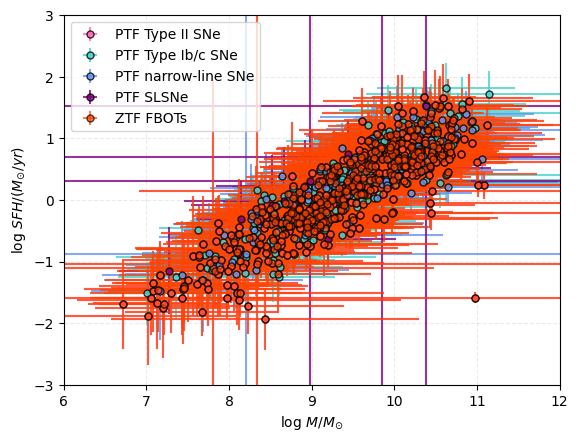

In [89]:
plt.errorbar(subtable_ii['log_stellar_mass'], subtable_ii['log_sfh'], yerr = subtable_ii['log_stellar_mass_err'], 
             xerr = subtable_ii['log_sfh_err'], marker = 'o', markerfacecolor = 'hotpink', markeredgecolor = 'black', 
             ecolor = 'hotpink', markersize = 5, linestyle = 'none', label = 'PTF Type II SNe', alpha = 0.8)
plt.errorbar(subtable_ibc['log_stellar_mass'], subtable_ibc['log_sfh'], yerr = subtable_ibc['log_stellar_mass_err'], 
             xerr = subtable_ibc['log_sfh_err'], marker = 'o', markerfacecolor = 'mediumturquoise', markeredgecolor = 'black', 
             ecolor = 'mediumturquoise', markersize = 5, linestyle = 'none', label = 'PTF Type Ib/c SNe', alpha = 0.8)
plt.errorbar(subtable_narrow['log_stellar_mass'], subtable_narrow['log_sfh'], yerr = subtable_narrow['log_stellar_mass_err'], 
             xerr = subtable_narrow['log_sfh_err'], marker = 'o', markerfacecolor = 'cornflowerblue', markeredgecolor = 'black', 
             ecolor = 'cornflowerblue', markersize = 5, linestyle = 'none', label = 'PTF narrow-line SNe', alpha = 0.8)
plt.errorbar(subtable_sl['log_stellar_mass'], subtable_sl['log_sfh'], yerr = subtable_sl['log_stellar_mass_err'], 
             xerr = subtable_sl['log_sfh_err'], marker = 'o', markerfacecolor = 'purple', markeredgecolor = 'black', 
             ecolor = 'purple', markersize = 5, linestyle = 'none', label = 'PTF SLSNe', alpha = 0.8)
plt.errorbar(subtable_fbots['log_stellar_mass'], subtable_fbots['log_sfh'], yerr = subtable_fbots['log_stellar_mass_err'], 
             xerr = subtable_fbots['log_sfh_err'], marker = 'o', markerfacecolor = 'orangered', markeredgecolor = 'black', 
             ecolor = 'orangered', markersize = 5, linestyle = 'none', label = 'ZTF FBOTs', alpha = 0.7)
plt.grid(alpha = 0.25, linestyle = '--')
plt.xlabel(r'log $M/M_{\odot}$')
plt.ylabel(r'log $SFH/(M_{\odot}/yr)$')
plt.legend()
plt.xlim(6, 12)
plt.ylim(-3, 3)
plt.show()

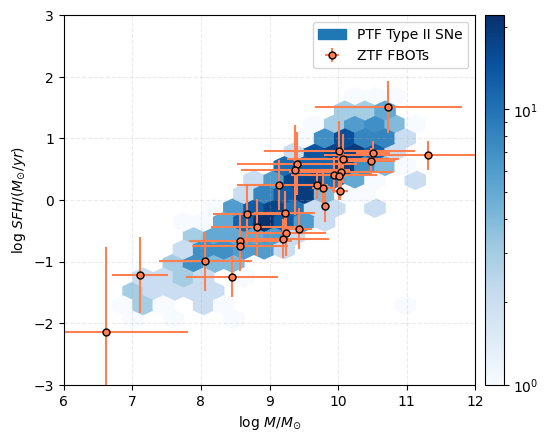

In [62]:
plt.errorbar(subtable_fbots['log_stellar_mass'], subtable_fbots['log_sfh'], yerr = subtable_fbots['log_stellar_mass_err'], 
             xerr = subtable_fbots['log_sfh_err'], marker = 'o', markerfacecolor = 'coral', markeredgecolor = 'black', 
             ecolor = 'coral', markersize = 5, linestyle = 'none', label = 'ZTF FBOTs')
plt.hexbin(subtable_ii['log_stellar_mass'], subtable_ii['log_sfh'], gridsize = 15, cmap = 'Blues', norm='log', label = 'PTF Type II SNe')
plt.colorbar(pad = 0.02)
plt.grid(alpha = 0.25, linestyle = '--')
plt.xlabel(r'log $M/M_{\odot}$')
plt.ylabel(r'log $SFH/(M_{\odot}/yr)$')
plt.legend()
plt.xlim(6, 12)
plt.ylim(-3, 3)
plt.show()

In [48]:
from scipy.stats import kstest
kstest(subtable_fbots['log_stellar_mass'], subtable_ii['log_stellar_mass'])

KstestResult(statistic=np.float64(0.09559017692104568), pvalue=np.float64(0.9478265236909208), statistic_location=np.float64(10.06946001460909), statistic_sign=np.int8(1))